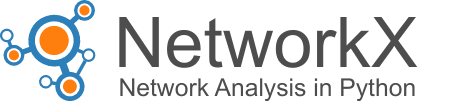

**This notebook is an implementation of ATP Hackathon using NetworkX Python library instead of Neo4j Graph Database and Cypher language. Will be presented the main methods and functionality of the library for Networks construction but also graph analysis.**

NetworkX is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks.

In [1]:
# necessary libraries import
import networkx as nx
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from importlib import reload
import helper

In [2]:
reload(helper)

<module 'helper' from 'C:\\Users\\LM532JA\\GitHub\\ATP_NetworkX\\notebooks\\helper.py'>

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Loading the preprocessed data, the same data as we had in ATP Hackathon

In [4]:
data_path = 'C:\\Users\\LM532JA\\GitHub\\ATP_NetworkX\\data\\processed\\data.csv'

In [6]:
data = pd.read_csv(data_path)

In [7]:
%%capture
data.info()

In [8]:
data.head()

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,...,ClmProcedureCode_5,PotentialFraud,Age,IsDead,DaysAdmitted,DaysClaimLasted,ClaimEndAfterDischarged,TotalDiagnosis,TotalProcedures,TotalPhysicians
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,...,NaN,1,66.0,0,7,7,0,9,5,1
1,BENE17521,1913-12-01,NaN,2,1,0,39,230,12,12,...,NaN,1,95.0,0,13,13,0,9,5,3
2,BENE21718,1922-10-01,NaN,1,1,0,39,600,12,12,...,NaN,1,87.0,0,19,19,0,9,5,2
3,BENE22934,1930-07-01,NaN,2,1,0,39,280,12,12,...,NaN,1,79.0,0,5,5,0,7,5,3
4,BENE24402,1925-09-01,NaN,2,2,0,39,510,12,12,...,NaN,1,83.0,0,5,5,0,1,5,2


# Creating the Graph

**Nodes Properties/Attributes names with Dataframe's columns map.**

In our initial dataframe the names of the columns do not correspond to the names of the attributes we have created in Neo4j hence bellow there is a mapping between the name of columns in graph and the initial columns' names. 

              

```json
           -- graph : "dataframe" --

Beneficiary:  gender:"Gender", 
              race:"Race",
              dob:"DOB",
              county:"County",
              state:"State",
              id:"BeneID",
              age:"Age",
              dod:"DOD"
                           
Claim :   reimbursedAmt:"InscClaimAmtReimbursed", 
          claimEndAfterDischarged:"ClaimEndAfterDischarged",
          admissionDate:"AdmissionDt",
          daysClaimLasted:"DaysClaimLasted",
          endDate:"ClaimEndDt",
          dischargeDate:"DischargeDt",
          deductibleAmt:"DeductibleAmtPaid",
          id:"ClaimID",
          startDate:"ClaimStartDt",
          daysAdmitted:"DaysAdmitted"
                   
Provider: fraud:"PotentialFraud",
          id: "Provider"
          
         
Condition: id:"conditionIdID"
           
        
Diagnosis: id:"ClmAdmitDiagnosisCode"
           
           
Physician: id:"physicianID"
           
          
Procedure: id:"procedureID"
           
```

**Nodes subcategories specifying.**

Regarding the following nodes: **Condition**, **Procedure**, **Physician** and **Diagnosis**, they are created from all the possible subcategories of each, hence we need to specify these subcategories.

In [157]:
# creating one list per node with their sub-categories columns
conditionCode = [
                 'RenalDiseaseIndicator','ChronicCond_Alzheimer','ChronicCond_Heartfailure',
                 'ChronicCond_KidneyDisease','ChronicCond_Cancer','ChronicCond_ObstrPulmonary',
                 'ChronicCond_Depression','ChronicCond_Diabetes','ChronicCond_IschemicHeart',
                 'ChronicCond_Osteoporasis','ChronicCond_rheumatoidarthritis','ChronicCond_stroke'
                ]

procedureCode = ['ClmProcedureCode_1','ClmProcedureCode_2',
                 'ClmProcedureCode_3','ClmProcedureCode_4',
                 'ClmProcedureCode_5'
                ]

physicianCode = ['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']

diagnosisCode = [
                 'ClmAdmitDiagnosisCode', 'DiagnosisGroupCode','ClmDiagnosisCode_1',
                 'ClmDiagnosisCode_2',   'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4',
                 'ClmDiagnosisCode_5',   'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7',
                 'ClmDiagnosisCode_8',   'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10'
                ]

Moreover, the same values are being repeated hence we need to create a list of all the possible distinct values for each of the nodes.

In [159]:
procedureID =  [*set([val for c in procedureCode for val in data[c].dropna().unique().tolist()])]
physicianID = [*set([val for c in physicianCode for val in data[c].dropna().unique().tolist()])]
diagnosisID  =  [*set([val for c in diagnosisCode for val in data[c].dropna().unique().tolist()])]

All in all, bellow is presented the final format the nodes and their attributes will be created into the graph.

```json
{Node Name: Node Values  :    {Attribute Name: Attribute Value}
                              }
Beneficiary
{"id":list(data["BeneID"]):   {
                             "label": 'Beneficiary',
                             "gender":list(data["Gender"]), 
                             "race":list(data["Race"]),
                             "dob":list(data["DOB"]),
                             "county":list(data["County"]),
                             "dod":list(data["DOD"]),
                             "state":list(data["State"]),
                             "age":list(data["Age"])
                              }}
   
Claim        
{"id":list(data["ClaimID"]):  {
                             "label": 'Claim',
                             "reimbursedAmt":list(data["InscClaimAmtReimbursed"]), 
                             "claimEndAfterDischarged":list(data["ClaimEndAfterDischarged"]),
                             "admissionDate":list(data["AdmissionDt"]),
                             "daysClaimLasted":list(data["DaysClaimLasted"]),
                             "endDate":list(data["ClaimEndDt"]),
                             "dischargeDate":list(data["DischargeDt"]),
                             "deductibleAmt":list(data["DeductibleAmtPaid"]),
                             "startDate":list(data["ClaimStartDt"]),
                             "daysAdmitted":list(data["DaysAdmitted"])
                              }}

Provider
{"id":list(data["Provider"]): {"label": 'Provider',
                               "fraud":list(data["PotentialFraud"])
                              }}

Condition         
{"id":conditionCode         :  {"label": 'Condition'}
                               }

Diagnosis
{"id":diagnosisID           :  {"label": 'Diagnosis'}
                               }

Physician
{"id":physicianID           :  {"label": 'Physician'}
                               }

Procedure
{"id":procedureID           :  {"label": 'Physician'}
                               }
```

**Creating a graph**
The graph is a MultiDiGraph as it allows to store multiple directed edges between two nodes. Each edge can hold optional data or attributes. It also provides the option of Nodes to be arbitrary (hashable) Python objects with optional key/value attributes and edges are represented as links between nodes with optional key/value attributes. 

Nodes and edges are not specified as NetworkX objects. This leaves us free to use meaningful items as nodes and edges.

In [160]:
# initializing our graph with name G
G = nx.MultiDiGraph()

## NODES
As the first step, the graph's nodes will be created.

NetworkX provides the following ways for nodes creation.
* **G.add_node()** one node at the time
* **G.add_nodes_from()** from any iterable container or from another graph

**Beneficiaries Nodes**

For each node we have to define the columns of our data we will need to specify the attributess.

In [161]:
#the initial columns of dataset we need as properties of the node
beneficiary = data[['BeneID','Gender','Race','DOB','County','DOD','State','Age']]

Each distinct beneficiary is a distinct node but since the same could appear more than once in our dataframe we have to specify the age as the latest one.

In [162]:
bage = pd.DataFrame({'BeneID':beneficiary.groupby('BeneID').max('Age')['Age'].index, 'Age':beneficiary.groupby('BeneID').max('Age')['Age'].values})

In [163]:
%%capture
# merge the two dataframes to create the final one and also add the Label column
beneficiary.drop('Age', axis=1, inplace=True)
beneficiary = pd.merge(beneficiary,bage,left_on='BeneID', right_on='BeneID')

In each node we add another attribute the "Label", as this is the only way to identify every node.

In [164]:
#add one more column which we will use as the label attribute
beneficiary['Label'] = 'Beneficiary'
beneficiary = beneficiary.drop_duplicates(keep='first')
beneficiary.set_index('BeneID', inplace=True)

# columns reindexing in order to display them in the same order as in Neo4j
beneficiary = beneficiary.iloc[:,[-1,0,1,2,3,4,5,6]]

#this is the final table before adding the nodes
beneficiary.head()

,Label,Gender,Race,DOB,County,DOD,State,Age
BeneID,,,,,,,,
BENE11001,Beneficiary,1,1,1943-01-01,230,NaN,39,67.0
BENE17521,Beneficiary,2,1,1913-12-01,230,NaN,39,95.0
BENE21718,Beneficiary,1,1,1922-10-01,600,NaN,39,87.0
BENE22934,Beneficiary,2,1,1930-07-01,280,NaN,39,79.0
BENE24402,Beneficiary,2,2,1925-09-01,510,NaN,39,83.0


In [165]:
# lowcase attributes
beneficiary.columns = [c.lower() for c in beneficiary.columns] 

In [166]:
# creating the dictionary
benefdict = beneficiary.to_dict(orient='index')

Bellow is the main NetworkX method for adding nodes in a graph using another data structure. 
**graph.add_nodes_from()**

In [167]:
# adding the nodes of Beneficiaries
G.add_nodes_from([(node, attr) for (node, attr) in benefdict.items()])

**Claims Nodes**

In [168]:
#the initial columns of dataset we need as properties
claims = data[['ClaimID','InscClaimAmtReimbursed','ClaimEndAfterDischarged','AdmissionDt','DaysClaimLasted','ClaimEndDt','DischargeDt','DeductibleAmtPaid','ClaimStartDt','DaysAdmitted']]

In [169]:
%%capture

#add one more column which we will use as the label attribute
claims['Label'] = 'Claim'

#reorder columns' index
claims.columns = ['id','reimbursedAmt','claimEndAfterDischarged','admissionDate','daysClaimLasted','endDate','dischargeDate','deductibleAmt','startDate','daysAdmitted', 'label']

In [170]:
# columns reindexing
claims = claims.iloc[:,[-1,0,1,2,3,4,5,6,7,8,9]]
claims.head()

,label,id,reimbursedAmt,claimEndAfterDischarged,admissionDate,daysClaimLasted,endDate,dischargeDate,deductibleAmt,startDate,daysAdmitted
0,Claim,CLM46614,26000,0,2009-04-12,7,2009-04-18,2009-04-18,1068.0,2009-04-12,7
1,Claim,CLM34721,19000,0,2009-01-20,13,2009-02-01,2009-02-01,1068.0,2009-01-20,13
2,Claim,CLM72336,17000,0,2009-10-17,19,2009-11-04,2009-11-04,1068.0,2009-10-17,19
3,Claim,CLM73394,13000,0,2009-10-25,5,2009-10-29,2009-10-29,1068.0,2009-10-25,5
4,Claim,CLM32911,3000,0,2009-01-08,5,2009-01-12,2009-01-12,1068.0,2009-01-08,5


In [171]:
# seting id as the index as it is the unique identifier which will be the name of the node 
claims.set_index('id', inplace=True)

In [172]:
claimdict = claims.to_dict(orient='index')

In [173]:
# adding the nodes of claims
G.add_nodes_from([(node, attr) for (node, attr) in claimdict.items()])

**Providers Nodes**

In [174]:
#the initial columns of dataset we need as properties
provider = data[["Provider",'PotentialFraud']]

In [175]:
%%capture

#add one more column which we will use as the label attribute
provider['Label'] = 'Provider'
provider.columns = ['id','fraud','label']

In [176]:
# we don't want the duplicates but only the main values
provider = provider.drop_duplicates(keep='first')

In [177]:
provider = provider.iloc[:,[-1,0,1]]
provider.head()

,label,id,fraud
0,Provider,PRV55912,1
60,Provider,PRV55907,0
120,Provider,PRV56046,0
134,Provider,PRV52405,0
156,Provider,PRV56614,0


In [178]:
provider.set_index('id', inplace=True)

In [179]:
providerdict = provider.to_dict(orient='index')

In [180]:
# adding the nodes of providers
G.add_nodes_from([(node, attr) for (node, attr) in providerdict.items()])

**Condition Nodes**

In [181]:
condict = helper.NodesCreation(conditionCode, 'Condition')

In [182]:
# adding the nodes of conditions
G.add_nodes_from([(node, attr) for (node, attr) in condict.items()])

**Diagnosis Nodes**

In [183]:
diagdict = helper.NodesCreation(diagnosisID, 'Diagnosis')

In [184]:
# adding the nodes of diagnosis
G.add_nodes_from([(node, attr) for (node, attr) in diagdict.items()])

**Physicians Nodes**

In [185]:
physdict = helper.NodesCreation(physicianID, 'Physician')

In [186]:
# adding the nodes of physician
G.add_nodes_from([(node, attr) for (node, attr) in physdict.items()])

**Procedures Nodes**

In [187]:
procdict = helper.NodesCreation(procedureID, 'Procedure')

In [188]:
# adding the nodes of procedure
G.add_nodes_from([(node, attr) for (node, attr) in procdict.items()])

In order to count the number of nodes we use the following method.
**G.number_of_nodes()**

In [189]:
# check the number of nodes
nx.number_of_nodes(G)

98972

## EDGES
Next step, the graph's edges will be created.

NetworkX provides the following ways for edges creation.
* **G.add_edge()** one node at the time
* **G.add_edges_from()** from any iterable container or from another graph

#### Beneficiary - Condition edges

In [190]:
# the data we need for the edge
bencondf = data.loc[:,['BeneID']+conditionCode].sort_values('BeneID')

In [191]:
#%%capture
bencondf

,BeneID,RenalDiseaseIndicator,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke
5847,BENE100002,0,1,1,0,0,1,1,1,1,0,0,1
39731,BENE100004,1,0,1,1,0,1,0,1,1,1,0,0
11838,BENE100006,0,1,0,1,0,1,0,1,1,0,0,0
4966,BENE100007,1,0,0,0,0,0,0,0,1,0,0,0
23953,BENE100010,0,0,1,1,1,1,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9498,BENE99965,0,1,1,0,0,0,0,0,1,0,0,0
13420,BENE99974,0,1,1,1,0,0,0,1,1,0,0,0
257,BENE99976,0,0,1,0,0,0,0,0,1,0,0,0
15793,BENE99984,0,1,1,0,0,0,1,1,1,0,0,0


In [192]:
bencondf.set_index('BeneID', inplace=True)

In [193]:
#%%capture
bencondf[bencondf==1]

,RenalDiseaseIndicator,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke
BeneID,,,,,,,,,,,,
BENE100002,NaN,1.0,1.0,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN,1.0
BENE100004,1.0,NaN,1.0,1.0,NaN,1.0,NaN,1.0,1.0,1.0,NaN,NaN
BENE100006,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN
BENE100007,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
BENE100010,NaN,NaN,1.0,1.0,1.0,1.0,NaN,1.0,1.0,NaN,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
BENE99965,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
BENE99974,NaN,1.0,1.0,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN
BENE99976,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [194]:
# creating a dictionary to be used for adding the data of edges by removing nan values which are not proper nodes' values.
# in case of 1 the specific condition is not a property of the beneficiary otherwise it is
bencondedges = {}
for i in range(bencondf.shape[0]):
    #print(i, np.where(bencondf.iloc[i,:]==1.0)[0])
    #print(bencondf.index[i],list(bencondf.iloc[i,np.where(bencondf.iloc[i,:]==1.0)[0]].index))
    bencondedges[bencondf.index[i]] = list(bencondf.iloc[i,np.where(bencondf.iloc[i,:]==1.0)[0]].index)

In [195]:
%%capture
bencondedges

Follows the main method for creating edges using a data structure. Also passing the label/name of the "connection".
**graph.add_edges_from()**

In [196]:
%%capture
# adding the edges
for k, v in bencondedges.items():
    G.add_edges_from(([(k, t) for t in v]), label= 'HAS_CONDITION')

#### Claim - Provider edges

In [197]:
# using the function we have created to add the edges.
clmprovedges = helper.AddSimpleEdge(data, ['ClaimID','Provider'], G, 'SUBMITTED_BY', False)

#### Claim - Procedure edges

An extra work is needed in this case to extract the unique procedure codes and also the cases we have an edge or not.

In [198]:
clmprocdf = data[['ClaimID',
                     'ClmProcedureCode_1',
                     'ClmProcedureCode_2',
                     'ClmProcedureCode_3',
                     'ClmProcedureCode_4',
                     'ClmProcedureCode_5'
                     ]].set_index('ClaimID').dropna(axis=0, how='all').dropna(axis=1, how='all')

In [199]:
clmprocdf['ClmProcedureCode'] = clmprocdf[['ClmProcedureCode_1', 'ClmProcedureCode_2',
                                           'ClmProcedureCode_3', 'ClmProcedureCode_4',
                                           'ClmProcedureCode_5']].apply(lambda x: helper.NewColumn(x), axis=1)

In [200]:
clmprocdf.reset_index(inplace=True)

In [201]:
clmprocedges = helper.AddSimpleEdge(clmprocdf, ['ClaimID','ClmProcedureCode'], G, 'HAS_PROCEDURE_CODE_OF', True)

#### Claim - Beneficiary edges

In [202]:
clmbenedges = helper.AddSimpleEdge(data, ['ClaimID','BeneID'], G, 'CREATED_FOR', False)

#### Claim - Diagnosis edges

In this case we have more than one way of connecting. The edges are seperated in three different types: 
**has diagnosis code of / has groupcode of / has admission with**

In [203]:
clmdiagnedges = data[['ClaimID']+diagnosisCode]

Edge Type: HAS_DIAGNOSIS_CODE_OF

In [204]:
diagnosiscodedf = clmdiagnedges.set_index('ClaimID').iloc[:,2:].dropna(axis=0, how='all').dropna(axis=1, how='all')

In [205]:
diagnosiscodedf['DiagnosisCode'] = diagnosiscodedf[['ClmDiagnosisCode_1','ClmDiagnosisCode_2','ClmDiagnosisCode_3','ClmDiagnosisCode_4','ClmDiagnosisCode_5','ClmDiagnosisCode_6','ClmDiagnosisCode_7','ClmDiagnosisCode_8','ClmDiagnosisCode_9','ClmDiagnosisCode_10']].apply(lambda x: helper.NewColumn(x), axis=1)

In [206]:
diagnosiscodedf.reset_index(inplace=True)

In [207]:
clmdiagcodedges = helper.AddSimpleEdge(diagnosiscodedf, ['ClaimID','DiagnosisCode'], G, 'HAS_DIAGNOSIS_CODE_OF', True)

Edge Type: HAS_GROUP_CODE_OF

In [208]:
clmdiaggroupcodedges = helper.AddSimpleEdge(clmdiagnedges, ['ClaimID','DiagnosisGroupCode'], G, 'HAS_GROUP_CODE_OF', False)

Edge Type: HAS_ADMISSION_WITH

In [209]:
clmdiagadmicodedges = helper.AddSimpleEdge(clmdiagnedges, ['ClaimID','ClmAdmitDiagnosisCode'], G, 'HAS_ADMISSION_WITH', False)

#### Claim - Physician edges

Another case with more than once type of connection, as there are the following types: 
**has attending / has operatig / has other**

In [210]:
clmphysedges = data[['ClaimID']+physicianCode].dropna(axis=0, how='all').dropna(axis=1, how='all')

Edge Type: HAS_ATTENDING

In [211]:
clmphysattenddf = clmphysedges[['ClaimID','AttendingPhysician']].dropna(axis=0, how='any')

In [212]:
clmphysattendedges = helper.AddSimpleEdge(clmphysattenddf, ['ClaimID','AttendingPhysician'], G, 'HAS_ATTENDING', False)

Edge Type: HAS_OPERATING

In [213]:
clmphysoperdf = clmphysedges[['ClaimID','OperatingPhysician']].dropna(axis=0, how='any')

In [214]:
clmphysoperedges = helper.AddSimpleEdge(clmphysoperdf, ['ClaimID','OperatingPhysician'], G, 'HAS_OPERATING', False)

Edge Type: HAS_OTHER

In [215]:
clmphysotherdf = clmphysedges[['ClaimID','OtherPhysician']].dropna(axis=0, how='any')

In [216]:
clmphysotherdges = helper.AddSimpleEdge(clmphysotherdf, ['ClaimID','OtherPhysician'], G, 'HAS_OTHER', False)

In order to count the number of edges we use the following method.
**G.number_of_edges()**

In [217]:
# check the number of edges
nx.number_of_edges(G)

757806

Using the method **graph.clear()** we delete everything in graph, but we don't really want something like that right now. In case we would like to remove specific nodes or edges, the suitable methods are:
**Graph.remove_node()** , **Graph.remove_edge()**

Let's save our graph now:

In [218]:
nx.write_gpickle(G, "C:\\Users\\LM532JA\\GitHub\\ATP_NetworkX\\graphs\\ATP_Graph.gpickle")

### After this procedure above we have created the same graph Network as we did in Neo4j. The same nodes and edges, with the same attributes and labels. The next step will be to analyze the network.!